In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib
import cvxpy as cp
from step_size import ConstantStepSize, SeqStepSize, StepSize
from functions import parse_logs

In [2]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 4,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

## Определения

**Определение.** Вектор $g(x)$ называется *субградиентом* функции $f$ в точке $x$, если $\forall y\in X$ выполнено

$$f(y) \geq f(x) + \langle g(x), y - x \rangle$$

*Субдифференциал* $\partial f(x)$ - это множество всех субградиентов (множество субградиентов выпукло).

Мы решаем задачу оптимизации

$$\min_{\mathbf{x}\in\mathbb{R}^n} f(\mathbf{x})$$

<!-- **Если $f(x^*)=\min_x f(x)$, то $0\in \partial f(x^*).$** -->

Условие $0\in \partial f(x^*)$ 
необходимо и достаточно для того, чтобы точка х* являлась решением минимизационной задачи).

## Субградиентный метод

Итерация субградиентного метода:

$$\mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k \mathbf{g}_k,$$

где $\mathbf{g}_k$ - субградиент в $\mathbf{x}_k$.

В чём отличия от обычного градиентного?  

- Фиксированный шаг уже не подойдёт, так как значение субградиента может не уменьшаться по мере приближения к $x^*$, как это было в гладком случае, и метод может "застревать". Пример: $f(x) = | x |$
- Метод наискорейшего спуска для подбора длины шага $\alpha_k = \text{argmin}_{\alpha > 0} f(x_k + \alpha s(x_k))$ так же не подойдёт, так как в субградиентном методе функция не обязательно убывает по направлению $- \partial f(x)$. Пример: $f(x) = |x_1 - x_2| + 0.2 |x_1 + x_2|$ в точке $\{1, 1\}$ в (см. Б.Т. Поляк "Введение в оптимизацию" с. 128)
- Без дополнительных условий сходится медленно. Но есть способы ускорить: проксимальный метод, ускоренный субградиентный метод, шаг Поляка

Размеры шага:

* Убывающая последовательность: $\alpha_k>0, \sum\limits_{i=1}^n \alpha_i =\infty, \sum\limits_{i=1}^n \alpha_i^2 <\infty$, $\alpha_k = \frac{\alpha_0}{k+1}$ или $\alpha_k = \frac{\alpha_0}{k \ln {k}}$ или $\alpha_k = \frac{\alpha_0}{k^\rho}$, где $\rho \in (0, 1]$

* Scaled gradient norm: $\alpha_k=\frac{\alpha_0}{\|g_k\|}$, $\alpha_0$ необходимо подбирать достаточно малым, чтобы гарантировать нужную точность

* Polyak step size: $\alpha_k=\frac{f_k-f^*}{\|g_k\|^2}$

Условия остановки

- Критерий $\| \nabla f(x) \| \leq \epsilon$ больше не работает
- Критерий $\| f(x_{k+1}) -  f(x_k) \| \leq \epsilon$ больше не работает
- Можно применять $\| x_{k+1} -  x_k \| \leq \epsilon$
- В качестве решения теперь берём либо среднее от k последних итераций либо рекордное значение


## Реализация субградиентного метода

In [3]:
class GradientDescent:
    def __init__(self, StepSizeChoice, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.history = []

    def solve(self, x0, f, gradf, tol=1e-3, max_iter=10000):
        self.history = [(x0, time.time())]
        x = x0.copy()
        k = 0
        x_prev = None
        while x_prev is None or np.linalg.norm(x - x_prev) > tol:
            h = -gradf(x)
            alpha = self.StepSizeChoice(x, h, k, gradf, f)
            x_prev, x = x, x + alpha * h
            if self.return_history:
                self.history.append((x, time.time()))
            if k >= max_iter:
                break
            k += 1
        return x

Нормированный шаг

In [4]:
class ScaledConstantStepSize(StepSize):
    def __init__(self, alpha0=0.5):
        self.alpha0 = alpha0

    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        return self.alpha0 / np.linalg.norm(gradf(x))

In [5]:
def alpha_function1(k):
    return min(1e-1/(k+1), 1e-4)

## Эксперимент 1. Решение СЛАУ

$$f(x) = \| Ax - b \|_1$$

Субградиент такой функции? Chain rule + modulus subgrad: $\partial \| Ax - b \|_1 = \text{sign} (|y|) \partial (Ax - b) = A^\top (\text{sign} (Ax - b))$

In [6]:
def func_l1(A, b):
    return lambda x: np.abs(A.dot(x) - b).sum()

def grad_f_l1(A, b):
    return lambda x: A.T @ np.sign(A.dot(x) - b)

In [7]:
np.random.seed(1)
n = 500
m = 100
A = np.random.randn(m, n)
x_true = np.random.rand(n)
b = A.dot(x_true)
x0 = np.ones(n)
f_l1 = func_l1(A, b)
gradf_l1 = grad_f_l1(A, b)

methods = [GradientDescent(ScaledConstantStepSize(1e-2), name="GD, scaled"),
           GradientDescent(ConstantStepSize(1e-4), name="GD, const"),
           GradientDescent(SeqStepSize(d=1, alpha0=2), name="GD, 1/k"),
           GradientDescent(SeqStepSize(alpha_function=alpha_function1), name="GD, custom"),
           ]

for method in methods:
    method.solve(x0, f_l1, gradf_l1, tol=1e-9, max_iter=10000)

Проанализируем результат:
- Почему GD, custom стал обгонять GD, const в какой-то момент времени?
- Почему GD, scaled обходит GD, const?

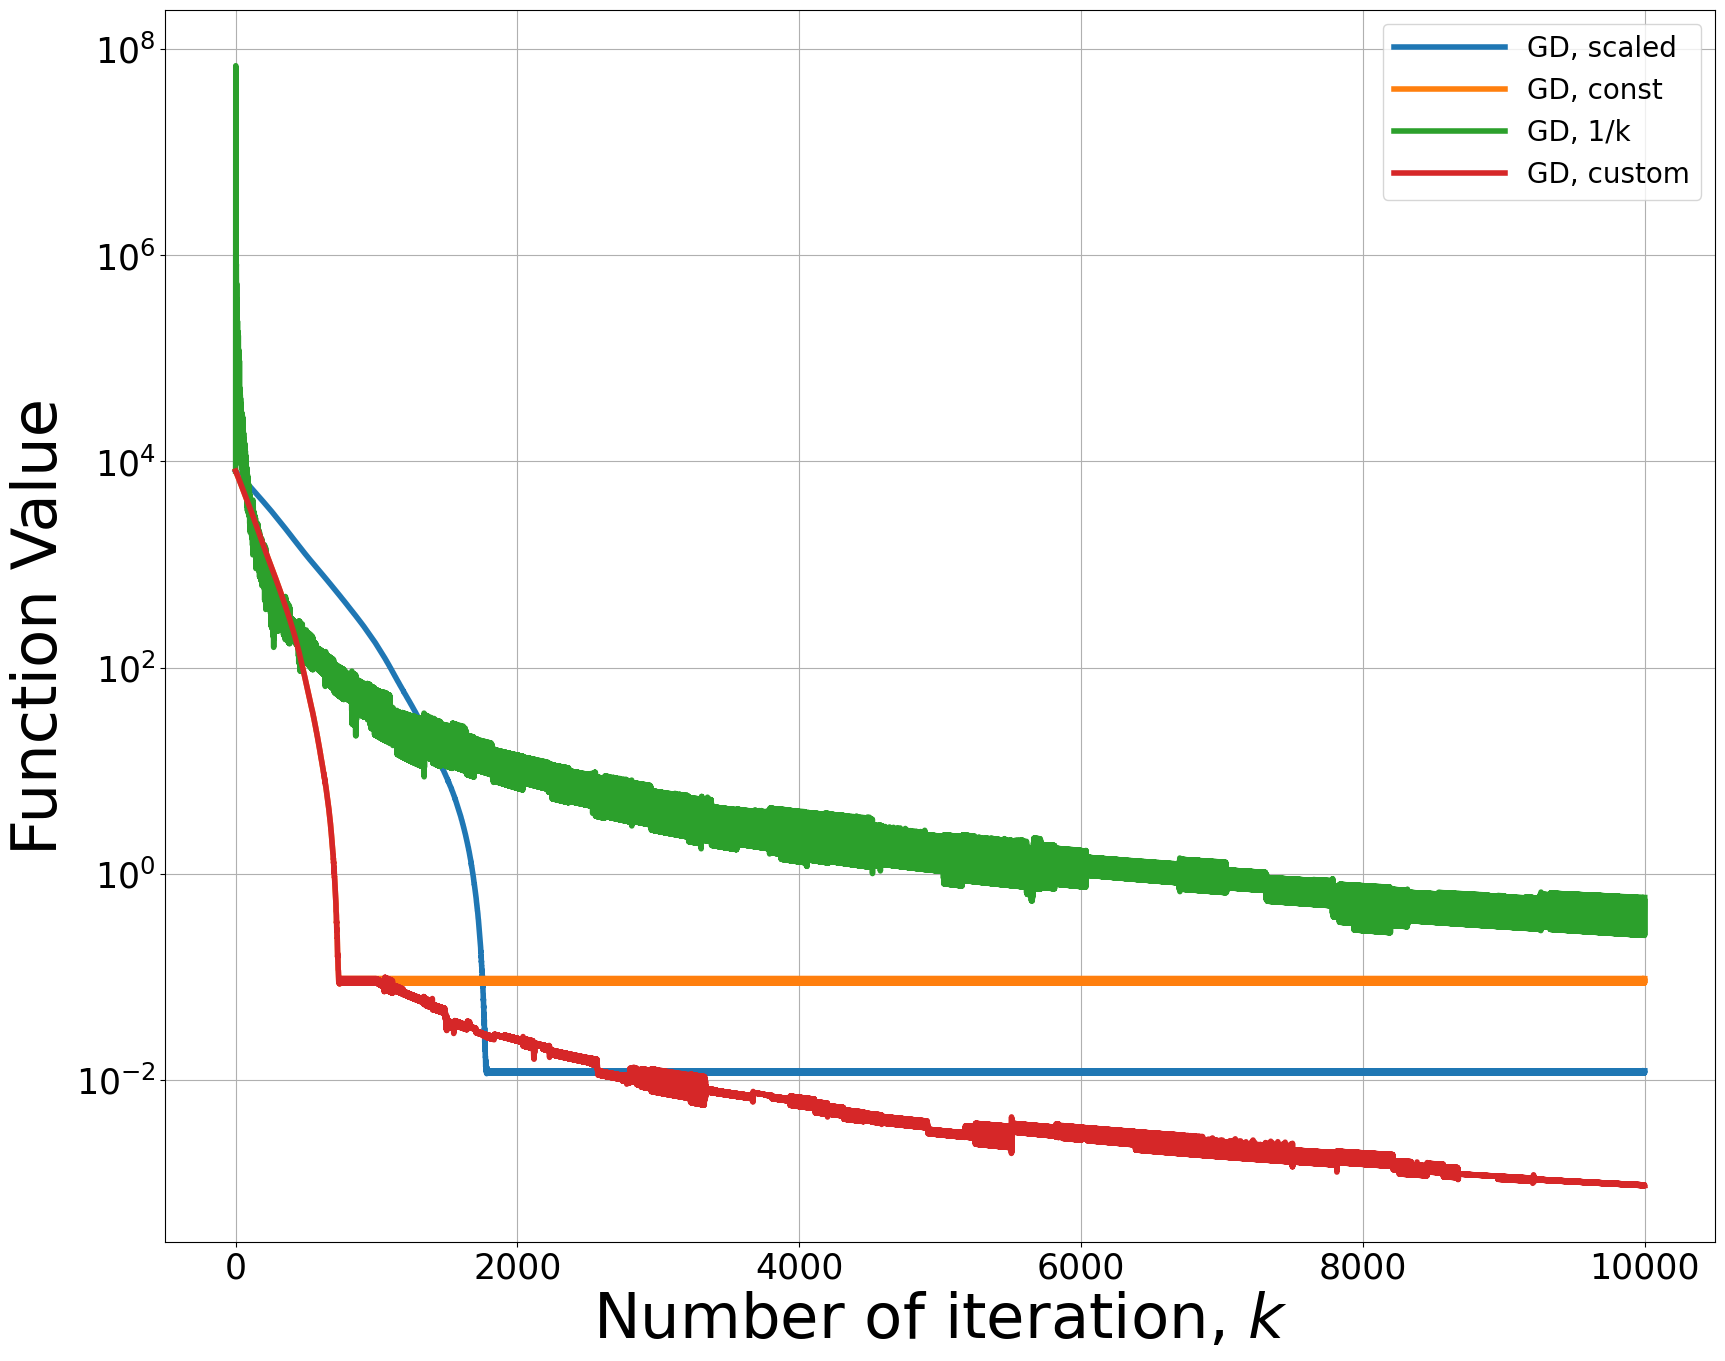

In [8]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: 1 / 2 * np.linalg.norm(A @ x - b, 2) ** 2
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)
plt.grid()
plt.ylabel(r"Function Value")
plt.xlabel(r"Number of iteration, $k$")
plt.legend();

## Эксперимент 2. Решение СЛАУ, $m\leq n$

$$\min_x f(x) = \|Ax-b\|_1$$

$$\min_x f(x) =  \|Ax-b\|_2^2$$

$$A\in\mathbb{R}^{m\times n}$$

Сравним близость к решению и скорость сходимости для гладкой и негладкой функции

In [9]:
def func_l2(A, b):
    return lambda x: np.linalg.norm(A.dot(x) - b) ** 2

def grad_f_l2(A, b):
    return lambda x: 2 * A.T.dot(A.dot(x) - b)

## Спуск по негладкой функции

In [10]:
np.random.seed(1)
n = 100
m = 500
A = np.random.randn(m, n)
x_true = np.random.rand(n)
b = A.dot(x_true)
x0 = np.ones(n)

f_l1 = func_l1(A, b)
gradf_l1 = grad_f_l1(A, b)

f_l2 = func_l2(A, b)
gradf_l2 = grad_f_l2(A, b)

Дополнительно определим шаг, чтобы сравнить его с другими вариантами шагов

In [11]:
def alpha_function1(k):
    return min(1e-1/(k+1), 1e-4)

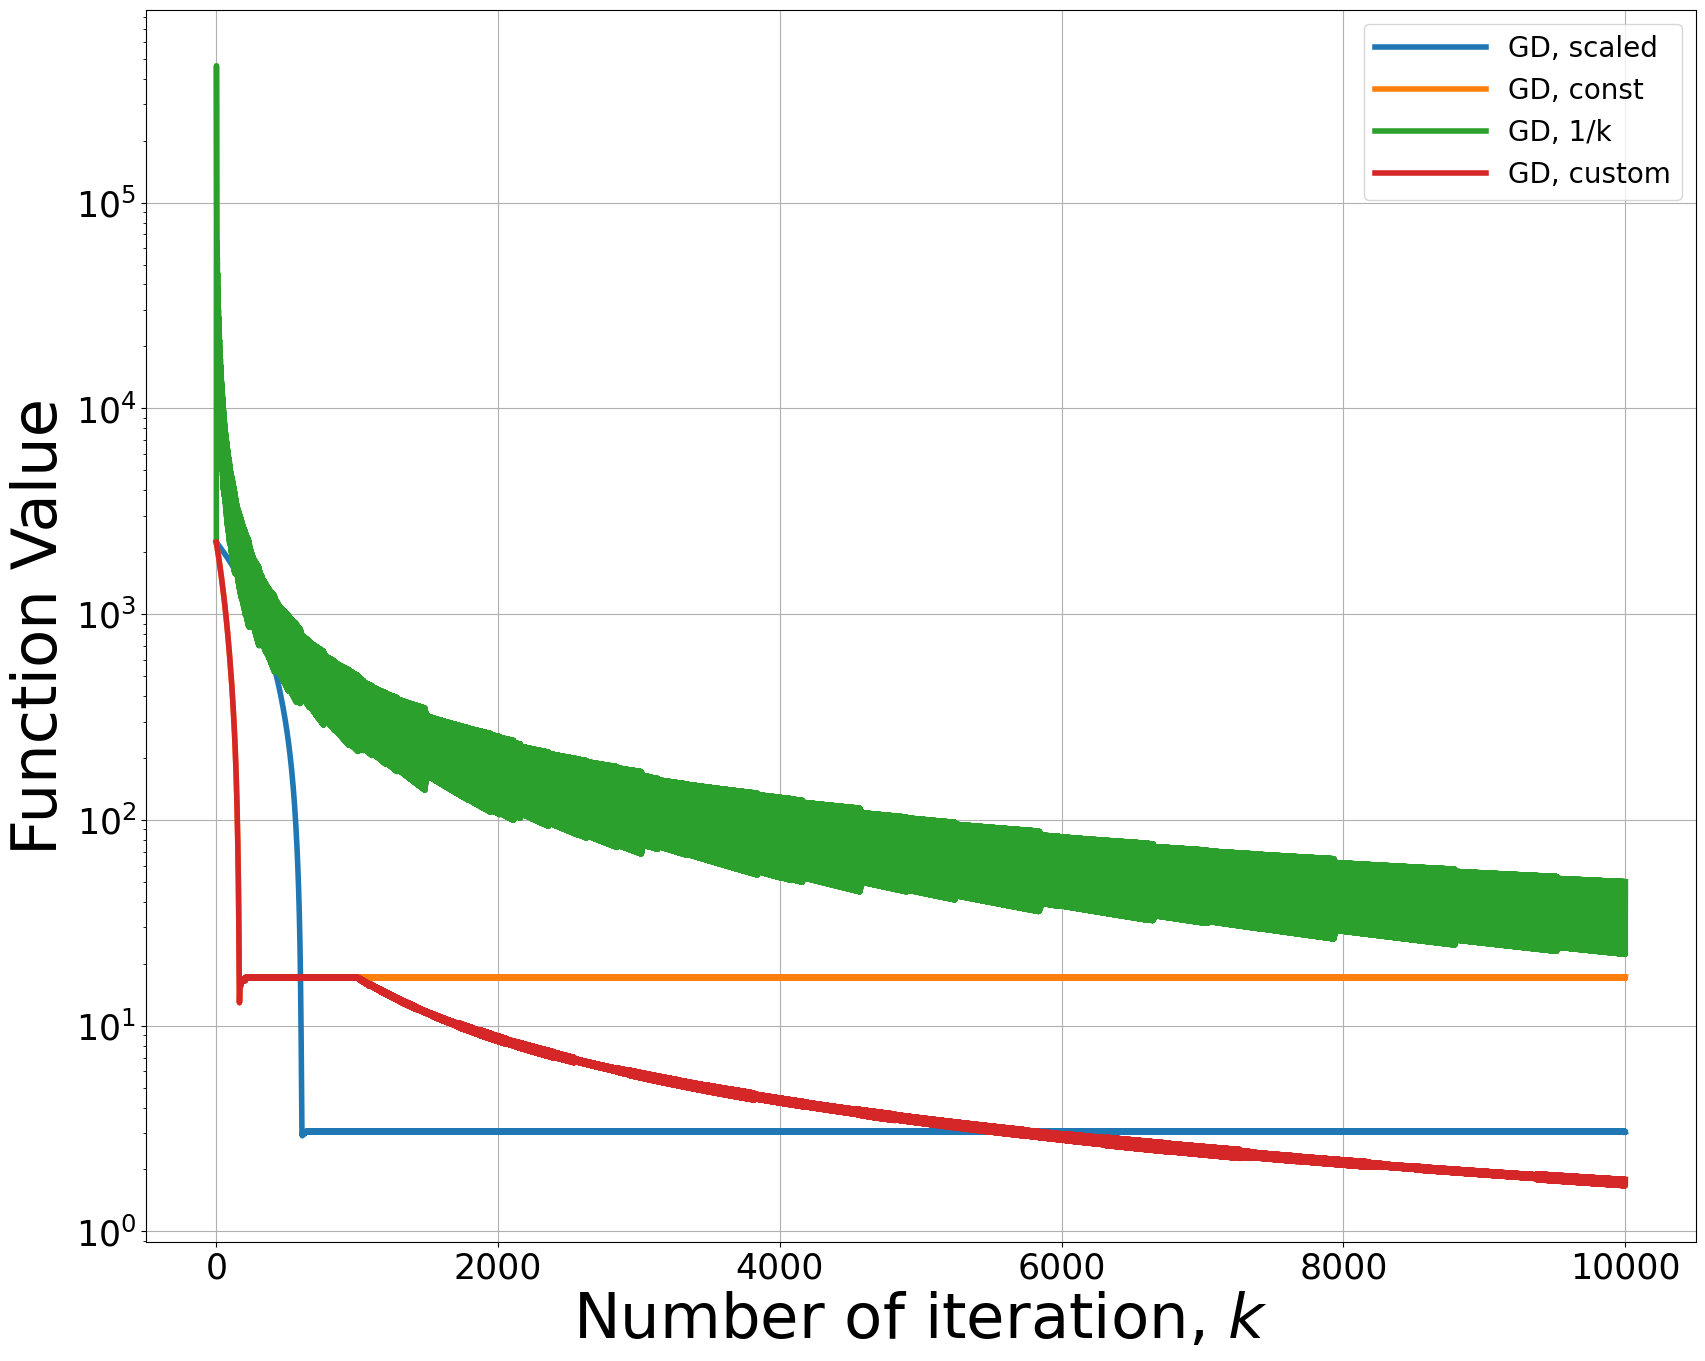

In [12]:
methods = [
           GradientDescent(ScaledConstantStepSize(1e-2), name="GD, scaled"),
           GradientDescent(ConstantStepSize(1e-4), name="GD, const"),
           GradientDescent(SeqStepSize(d=1, alpha0=2), name="GD, 1/k"),
           GradientDescent(SeqStepSize(alpha_function=alpha_function1), name="GD, custom"),
           ]

for method in methods:
    method.solve(x0, f_l1, gradf_l1, tol=1e-9, max_iter=10000)

plt.figure(figsize=(20, 16))
funcx = lambda x: func_l1(A, b)(x)
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)
plt.grid()
plt.ylabel(r"Function Value")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()

## Спуск по гладкой функции

Как видим гладкий случай сходится быстрее

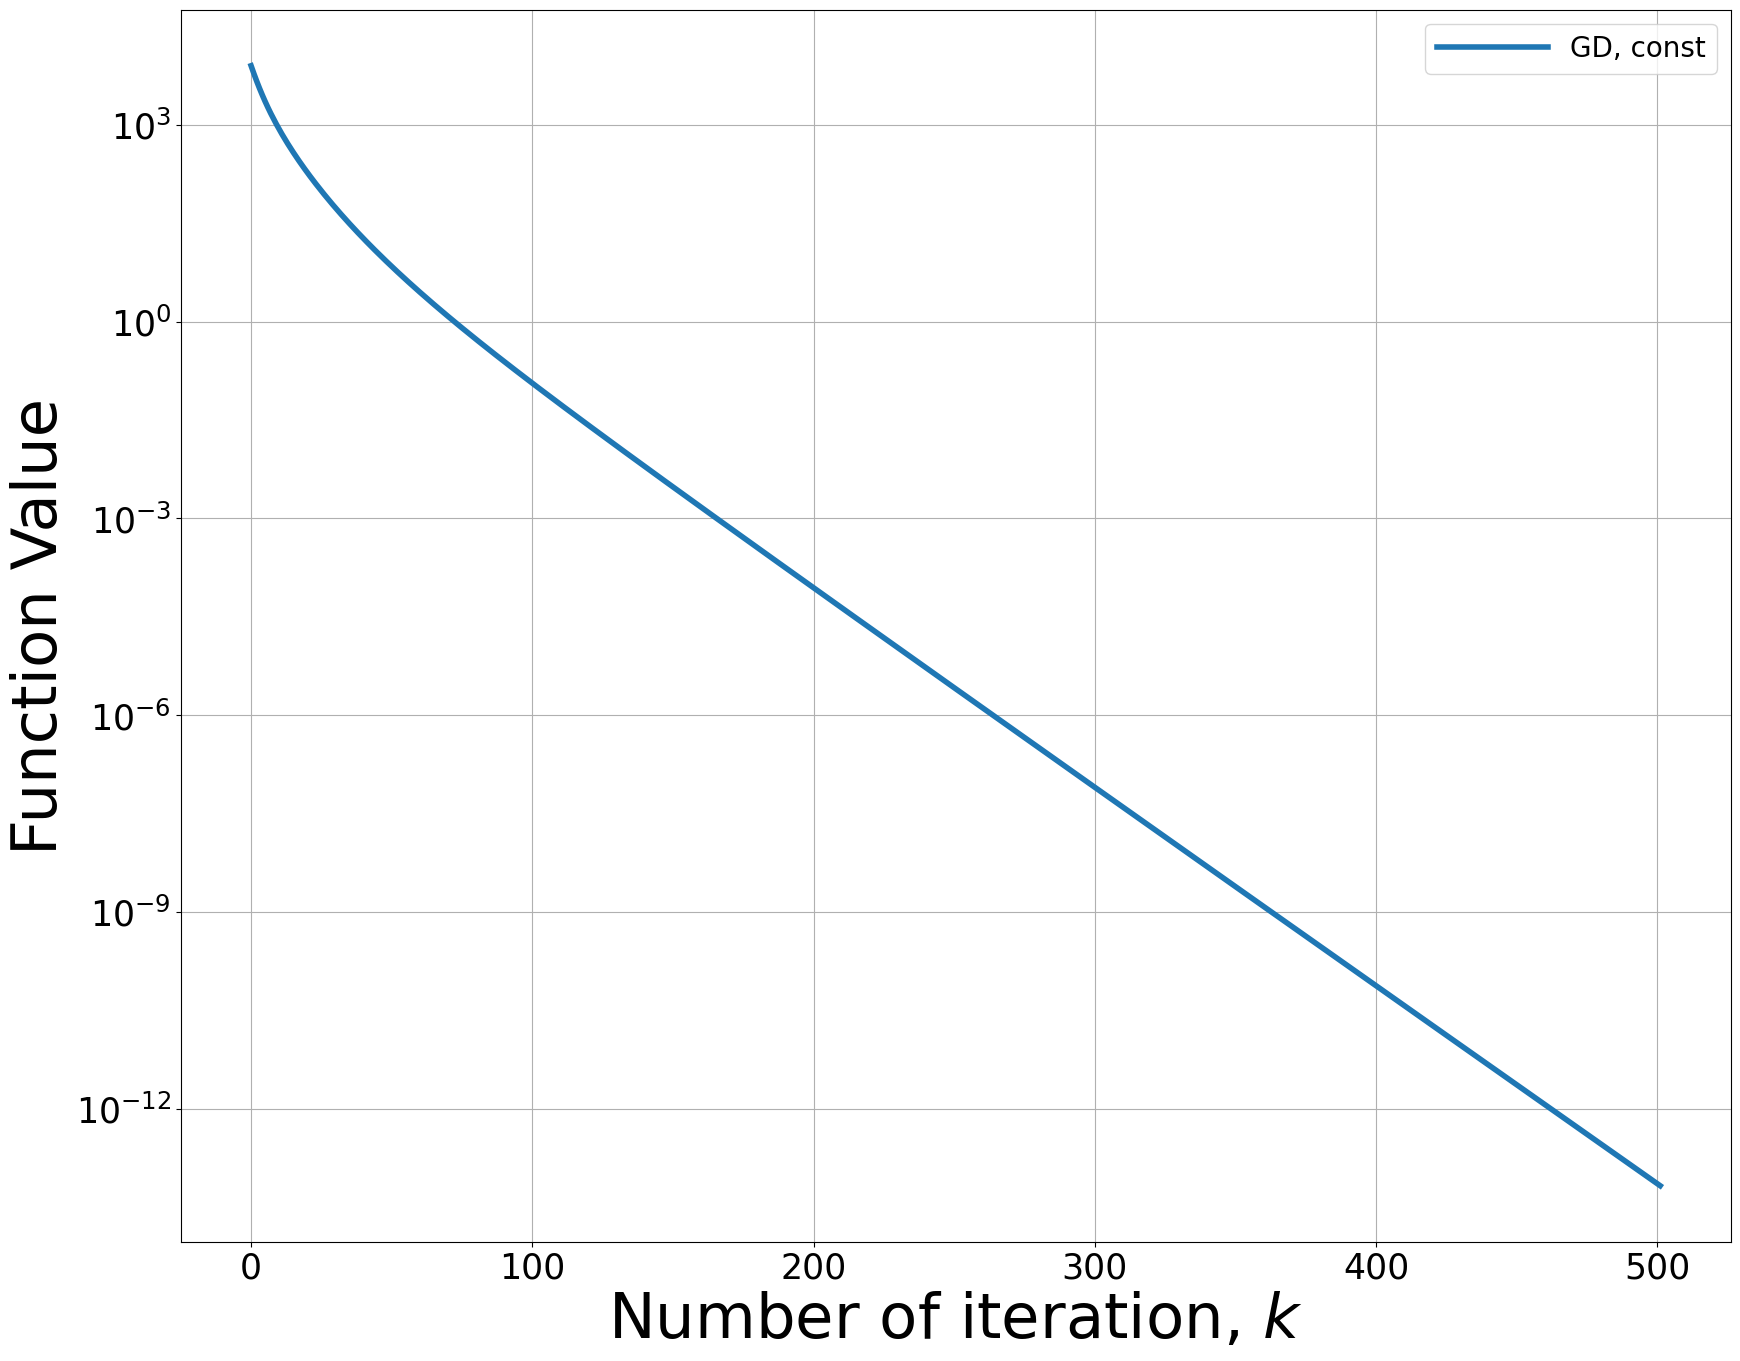

In [13]:
methods = [GradientDescent(ConstantStepSize(1e-4), name="GD, const")]
for method in methods:
    method.solve(x0, f_l2, gradf_l2, tol=1e-9, max_iter=1000)

plt.figure(figsize=(20, 16))
funcx = lambda x: 1 / 2 * f_l2(x)

for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)
plt.grid()
plt.ylabel(r"Function Value")
plt.xlabel(r"Number of iteration, $k$")
plt.legend();

## Шаг Поляка

$$\alpha_k=\frac{f_k-f^*}{\|g_k\|^2}$$

__Примечание__ Для применения шага нужно знать решение $f^*$  
__Примечание__ Шаг даёт оптимальные оценки, поэтому в теории среди субградиентных методов он один из самых быстрых  
__Примечание__ Чем дальше от решения, тем длиннее шаг. Почему не применить для обычных дифференцирумых функций? На самом деле можно, но оптимальные оценки даёт на субградиентном  

А как узнать решение?

In [14]:
class PolyakStepSize(StepSize):
    def __init__(self, f_sol=0):
        self.f_sol = f_sol

    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        return (f(x) - self.f_sol) / np.linalg.norm(gradf(x)) ** 2

In [15]:
np.random.seed(1)
n = 500
m = 100
A = np.random.randn(m, n)
x_true = np.random.rand(n)
b = A.dot(x_true)
x0 = np.ones(n)

f_l1 = func_l1(A, b)
gradf_l1 = grad_f_l1(A, b)

In [16]:
methods = [GradientDescent(PolyakStepSize(0), name="GD, Polyak"),
           GradientDescent(SeqStepSize(alpha_function=alpha_function1), name="GD, custom"),
           ]

for method in methods:
    method.solve(x0, f_l1, gradf_l1, tol=1e-9, max_iter=10000)

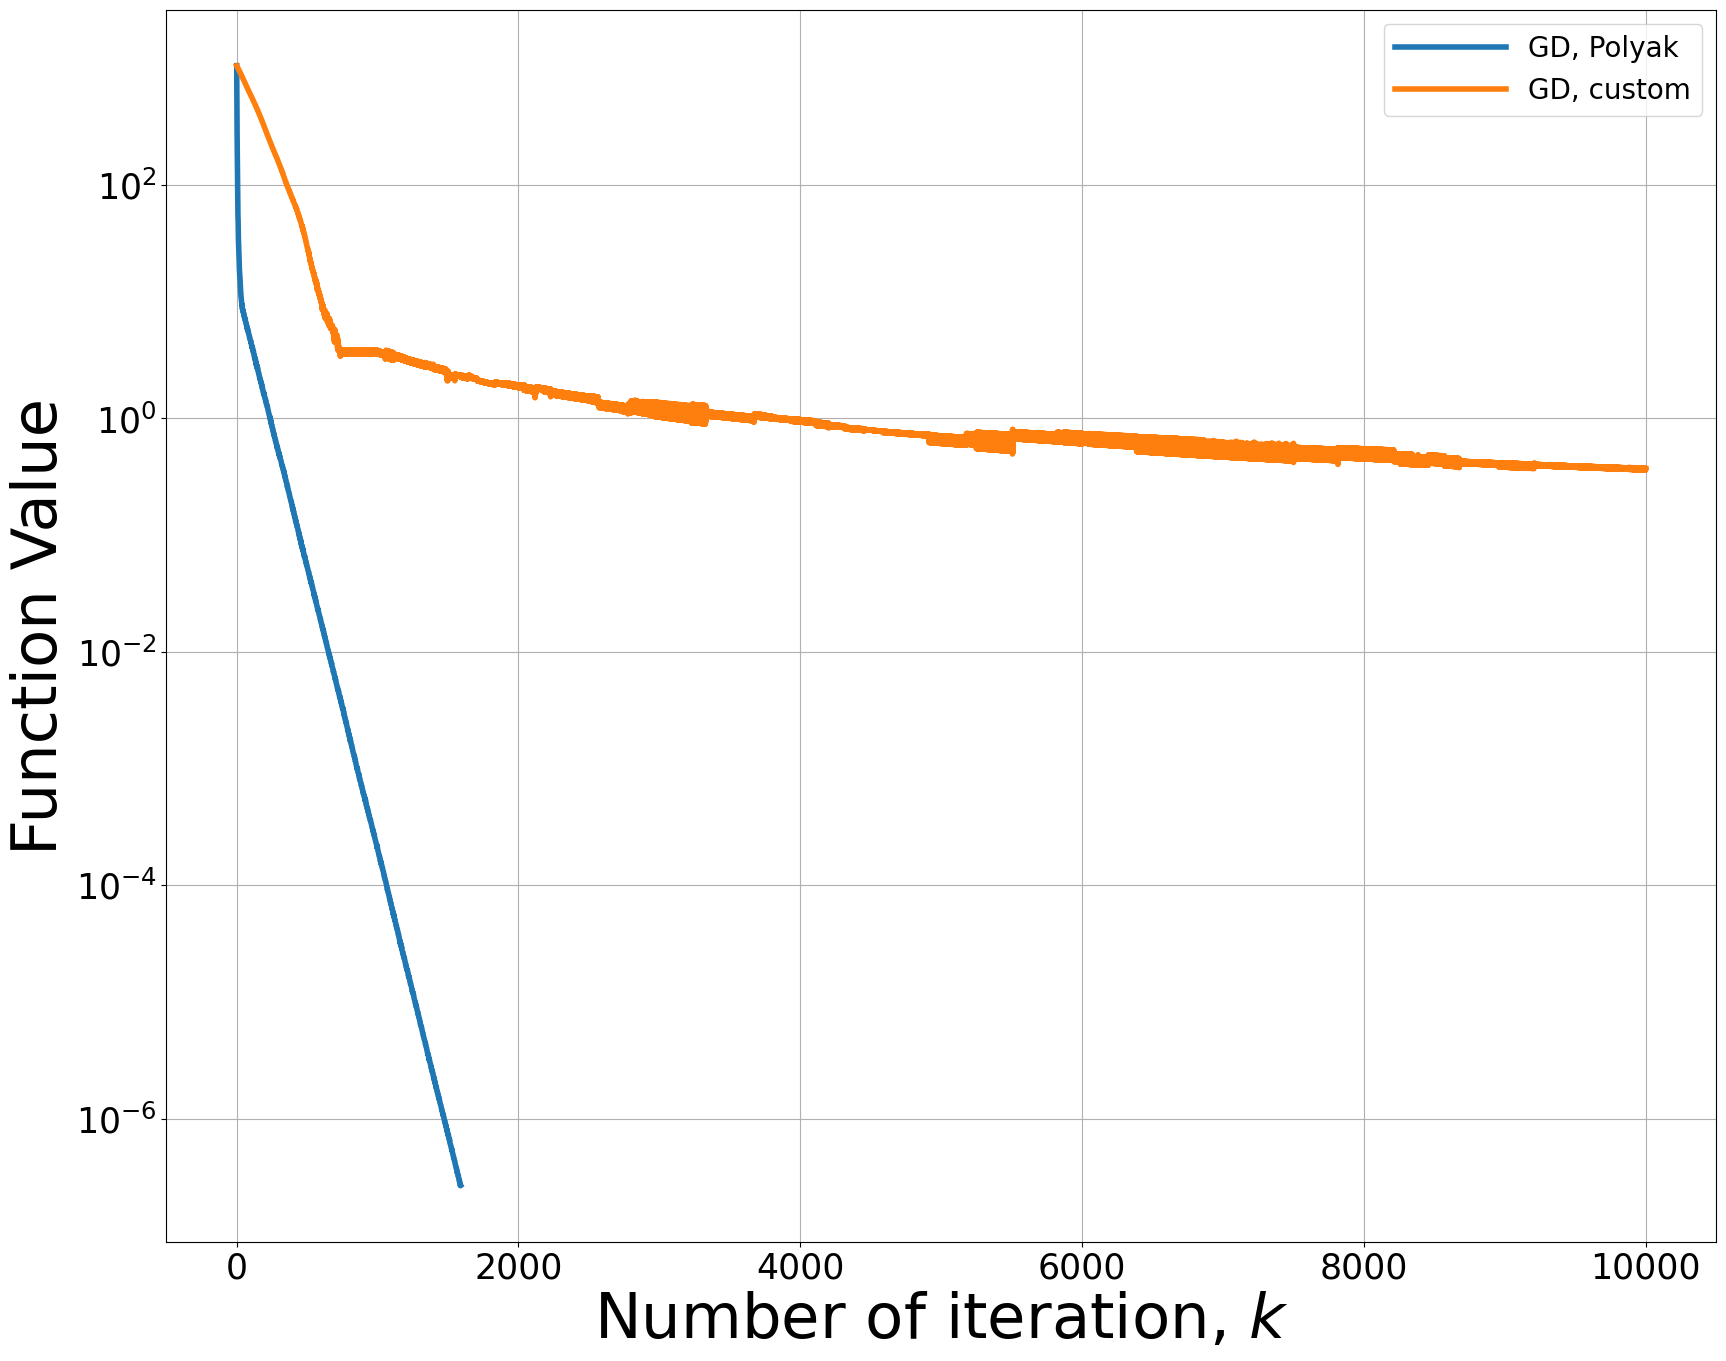

In [17]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: f_l1(x)
# funcx = lambda x: f(x)
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)
plt.grid()
plt.ylabel(r"Function Value")
plt.xlabel(r"Number of iteration, $k$")
plt.legend();

## Сравним два метода решения СЛАУ более подробно

In [18]:
np.random.seed(1)
n = 500
m = 1000
A = np.random.randn(m, n)
x_true = np.random.randn(n)
b = A.dot(x_true) + np.random.randn(m)
x0 = np.ones(n)

f_l1 = func_l1(A, b)
gradf = grad_f_l1(A, b)
f_l2 = func_l2(A, b)
gradf_l2 = grad_f_l2(A, b)

method = GradientDescent(SeqStepSize(alpha_function=alpha_function1), name="Subgrad")
x_l1 = method.solve(x0, f_l1, gradf, tol=1e-4, max_iter=6000)

method = GradientDescent(ConstantStepSize(1e-4), name="Grad")
x_l2 = method.solve(x0, f_l2, gradf_l2, tol=1e-4, max_iter=6000)

На "своей" минимизации результат лучше как и следовало ожидать

In [19]:
print('l1: ' + str(f_l1(x_l1)), 'l2: ' + str(f_l2(x_l1)))
print('l1: ' + str(f_l1(x_l2)), 'l2: ' + str(f_l2(x_l2)))

l1: 457.20382013389985 l2: 677.6310216915264
l1: 542.0383552287337 l2: 471.27847091674545


Ярко видим, что количество разреженных компонент гораздо выше у l1 нормы

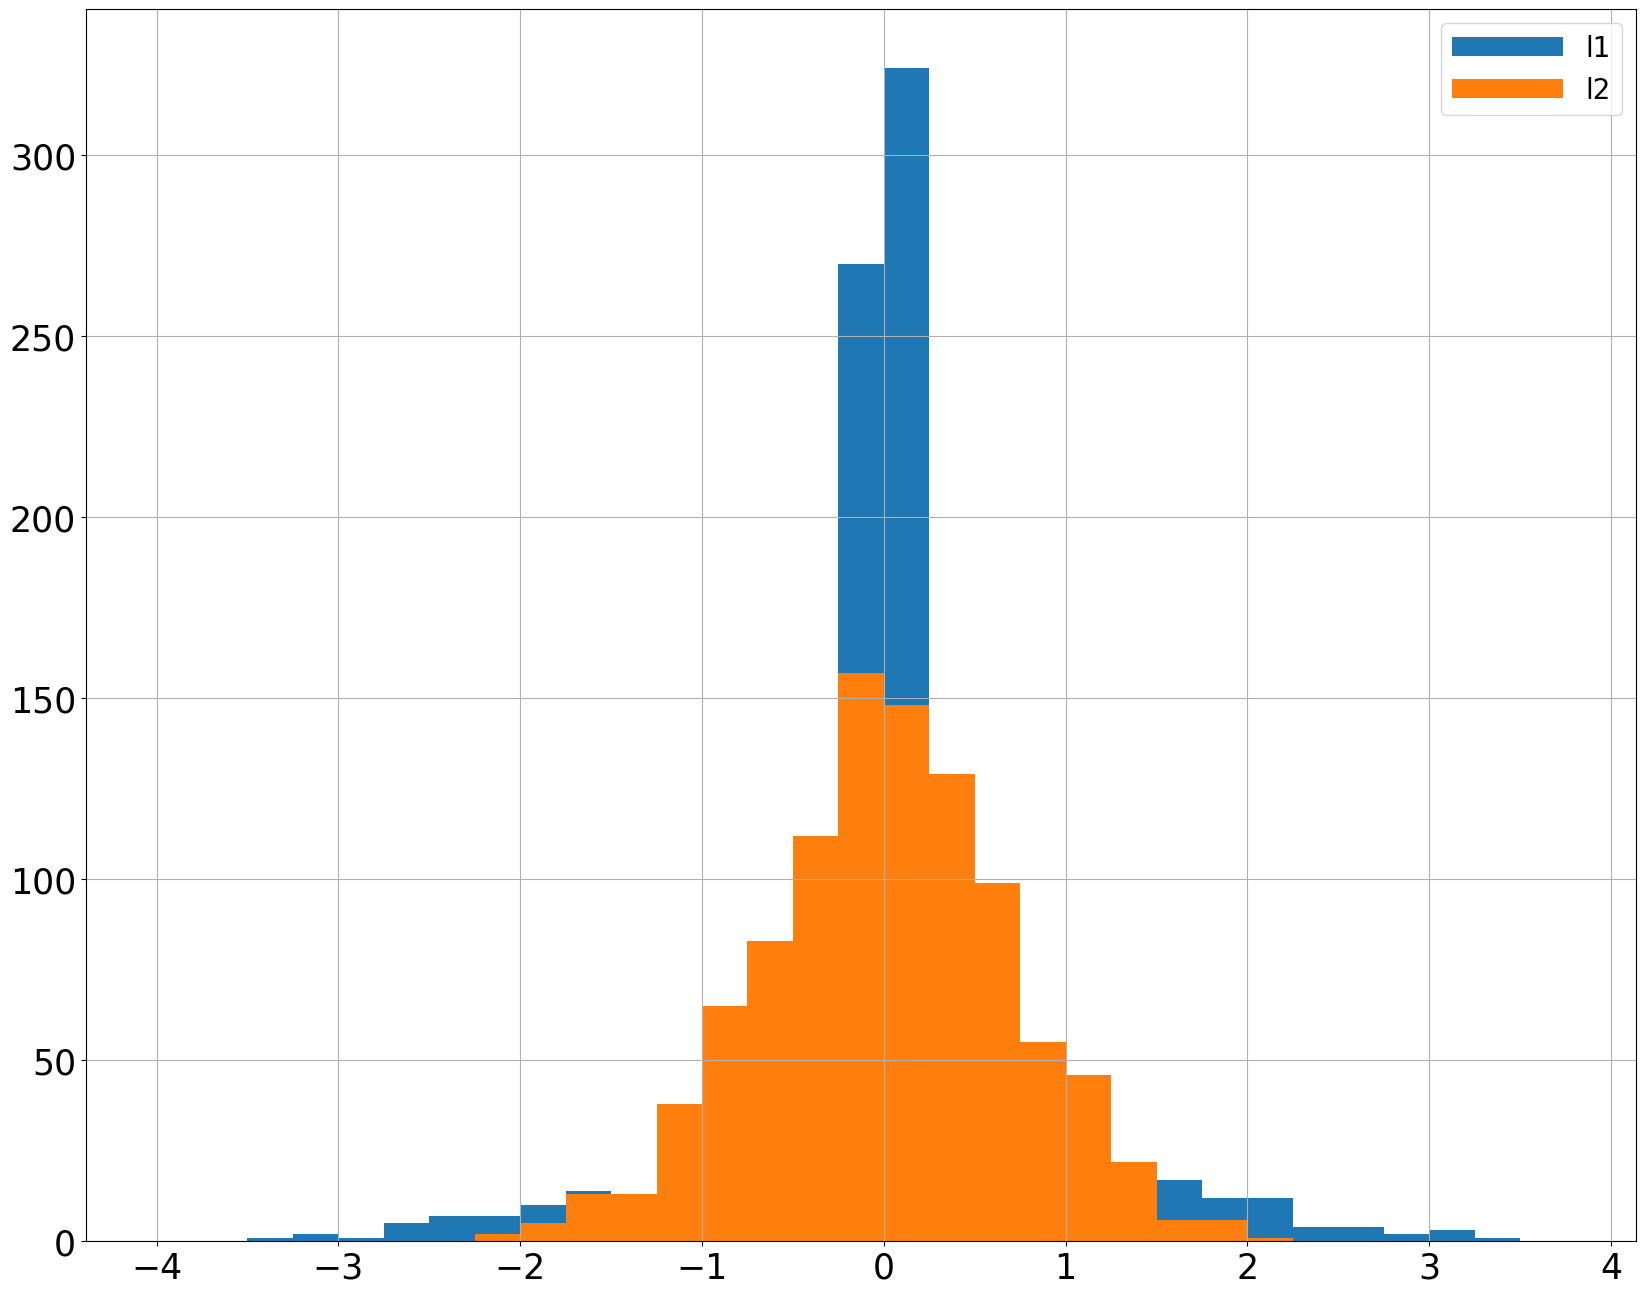

In [20]:
%matplotlib inline
plt.figure(figsize=(20, 16))
plt.hist(A @ x_l1 - b, np.arange(-4, 4, 0.25), label="l1")
plt.hist(A @ x_l2 - b, np.arange(-4, 4, 0.25), label="l2")
plt.legend()
plt.grid()

## Эксперимент 3. Maximum eigenvalue of a symmetric matrix

Применим субградиентный метод для задач типа 
$$f(x)=\operatorname{sup}_{\alpha \in A} f_\alpha (x)$$
, где $A$ - множество индексов функций $f(x) = f_\alpha(x)$  
Тогда субградиентом такой функции будет выпуклая оболочка:  
$$\partial f(x) = \text{Co} \cup {\partial f_\alpha(x) \ | \ f_\alpha(x) = f(x)}$$

Теперь рассмотрим задачу
$$
\min_{x \in \mathbb{R}^n} \lambda_{\text{max}}(A(x)),
$$
где $A(x) = A_0 + x_1 A_1 + x_2 A_2 + ... + x_n A_n$ и $A_i \in S^m$.

Чтобы найти субградиент, преобразуем задачу к виду:
$$
f(x) = \lambda_{\text{max}}(A(x)) = \text{sup}_{\| y \|_2 = 1} y^\top A(x) y,
$$

Тогда для каждого $x$ и фиксированного $y$ по теореме Дубовитского-Милютина (subdifferential of a point-wise maximum) субградиент нашей функции равен:
$\nabla f_y (x) = (y^\top A_1 y, ..., y^\top A_n y)$

Подробности см. https://web.stanford.edu/class/ee364b/lectures/subgradients_notes.pdf c.8

In [21]:
def func(sym_mx_ar):
    def f(x):
        eigenvalues = np.linalg.eigvalsh((sym_mx_ar * x[:, np.newaxis, np.newaxis]).sum(axis=0))
        return eigenvalues.max()

    return lambda x: f(x)


def grad_f(sym_mx_ar):
    m = sym_mx_ar.shape[0]
    derivative = np.zeros(m)

    def f(x):
        eigenvalues, eigenvectors = np.linalg.eig((sym_mx_ar * x[:, np.newaxis, np.newaxis]).sum(axis=0))
        max_unit_eigvec = eigenvectors[np.argmax(eigenvalues)]
        for i in range(m):
            derivative[i] = max_unit_eigvec.T.dot(sym_mx_ar[i]).dot(max_unit_eigvec)
            return derivative

    return lambda x: f(x)

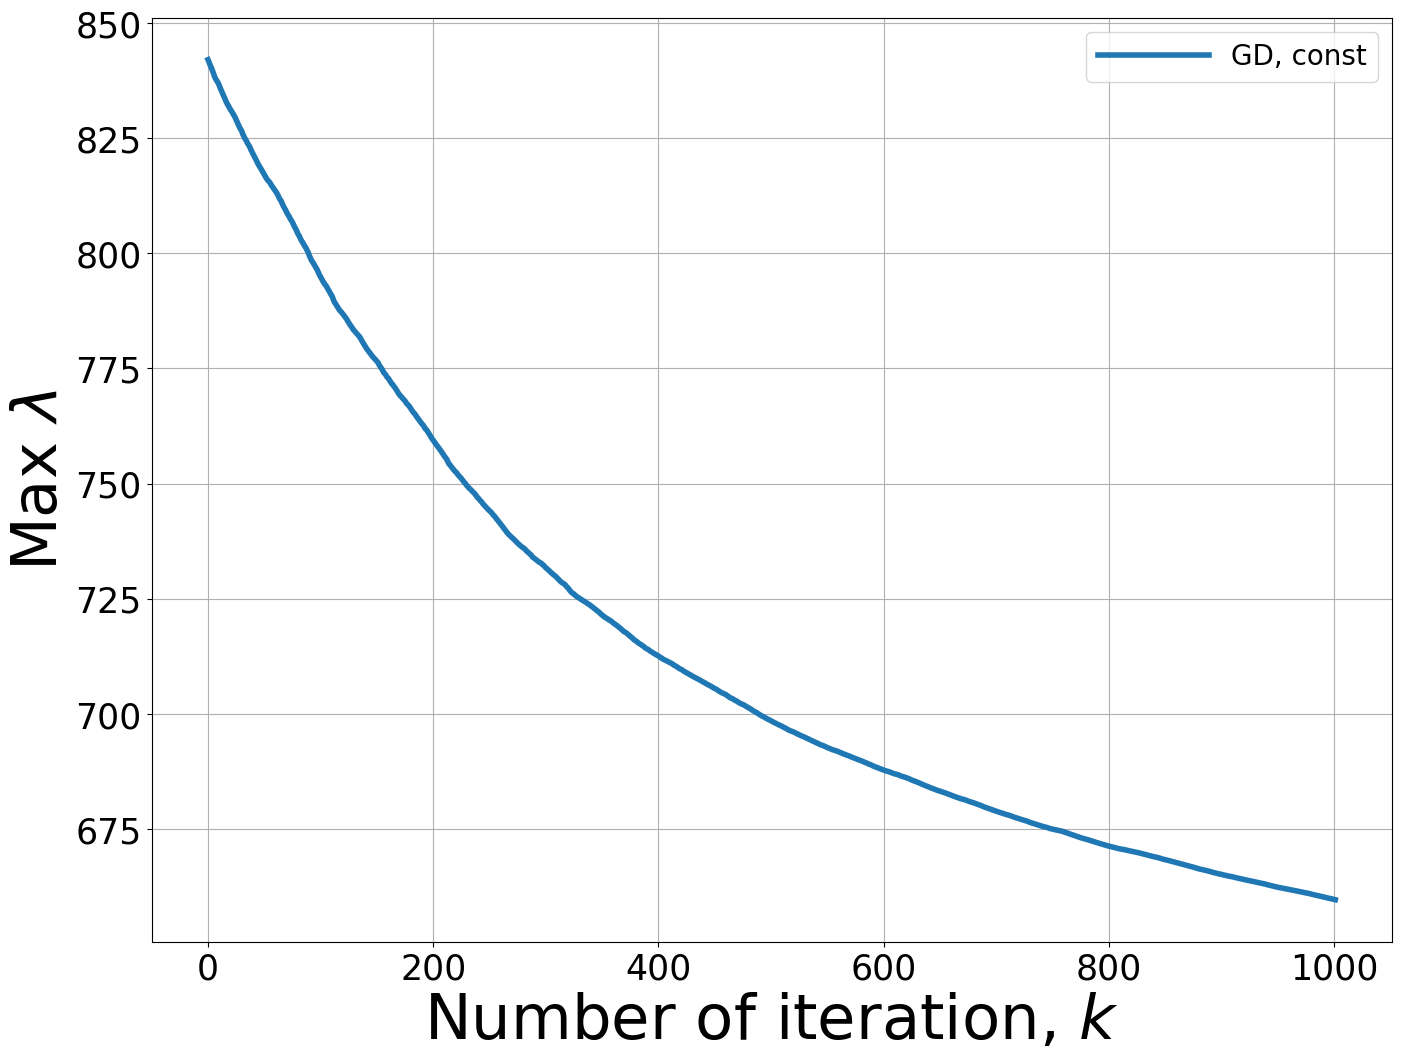

In [22]:
np.random.seed(1)
n = 50
mx_count = 10

sym_mx_ar = []
for i in range(mx_count):
    A = np.random.randn(n, n)
    A = A.T.dot(A)
    sym_mx_ar.append(A)
sym_mx_ar = np.array(sym_mx_ar)

x0 = np.ones(mx_count)

f = func(sym_mx_ar)
gradf = grad_f(sym_mx_ar)

methods = [GradientDescent(SeqStepSize(alpha_function=alpha_function1), name="GD, const")]

for method in methods:
    method.solve(x0, f, gradf, tol=1e-9, max_iter=1000)

plt.figure(figsize=(16, 12))
funcx = lambda x: f(x)
for method in methods:
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.plot(times, values, label=method.name)
plt.grid()
plt.ylabel(r"Max $\lambda$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()

## Эксперимент 4: LASSO
LASSO (Least Absolute Shrinkage and Selection Operator):

$$\min_x \|Ax-b\|_2^2 + \sigma \|x\|_1$$  

- А как можно хотя бы примерно определить решение для шага Поляка? Например, хотя бы приблизительное решение можно найти в CVXPY

In [23]:
def func(x, A, b, sigma):
    return 1/2 * np.linalg.norm(A @ x - b)**2/A.shape[0] + sigma * np.abs(x).sum()

def grad_f(x, A, b, sigma):
    return A.T @ (A @ x - b)/A.shape[0] + sigma * np.sign(x)

Протестируем ещё один шаг:

$\alpha(k) = \max\left(3^{-\left\lfloor\frac{k}{1000}\right\rfloor}, 10^{-5}\right) \times 0.5$

In [24]:
def alpha_function2(k):
    return max(3**(-k//1000), 1e-5)*0.5

In [25]:
np.random.seed(1)
n = 500
m = 100
A = np.random.randn(m, n)
x_true = np.random.rand(n)
b = A.dot(x_true)
x0 = np.zeros(n)
sigma = 1e-1
eps = 1e-9

In [26]:
f = lambda x: func(x, A, b, sigma)
gradf = lambda x: grad_f(x, A, b, sigma)

x = cp.Variable(n)
obj = cp.Minimize(1 / 2 * cp.norm(A @ x - b) ** 2 / A.shape[0] + sigma * cp.norm(x, 1))
cp.Problem(obj).solve()
x = x.value
f(x), np.sum(np.abs(x) <= eps)

methods = [GradientDescent(SeqStepSize(alpha_function=alpha_function2), name="GD, custom"),
           GradientDescent(SeqStepSize(d=1 / 2, alpha0=.5), name="GD, 1/k"),
           GradientDescent(ConstantStepSize(1e-2), name="GD, const"),
           GradientDescent(PolyakStepSize(f(x)), name="GD, Polyak")]

for method in methods:
    x = method.solve(x0, f, gradf, tol=1e-9, max_iter=40000)
    print(method.name, f(x))

GD, custom 7.297937102398342
GD, 1/k 7.304769989417855
GD, const 7.309148805408762
GD, Polyak 7.299125729699756


Проанализируем результат:
- Каждое переключение $k$ в новом шаге ассоциировано со ступенькой на графике
- Как видим, нам удалось подобрать шаг, который обошёл оптимальный. На практике многое может отличаться

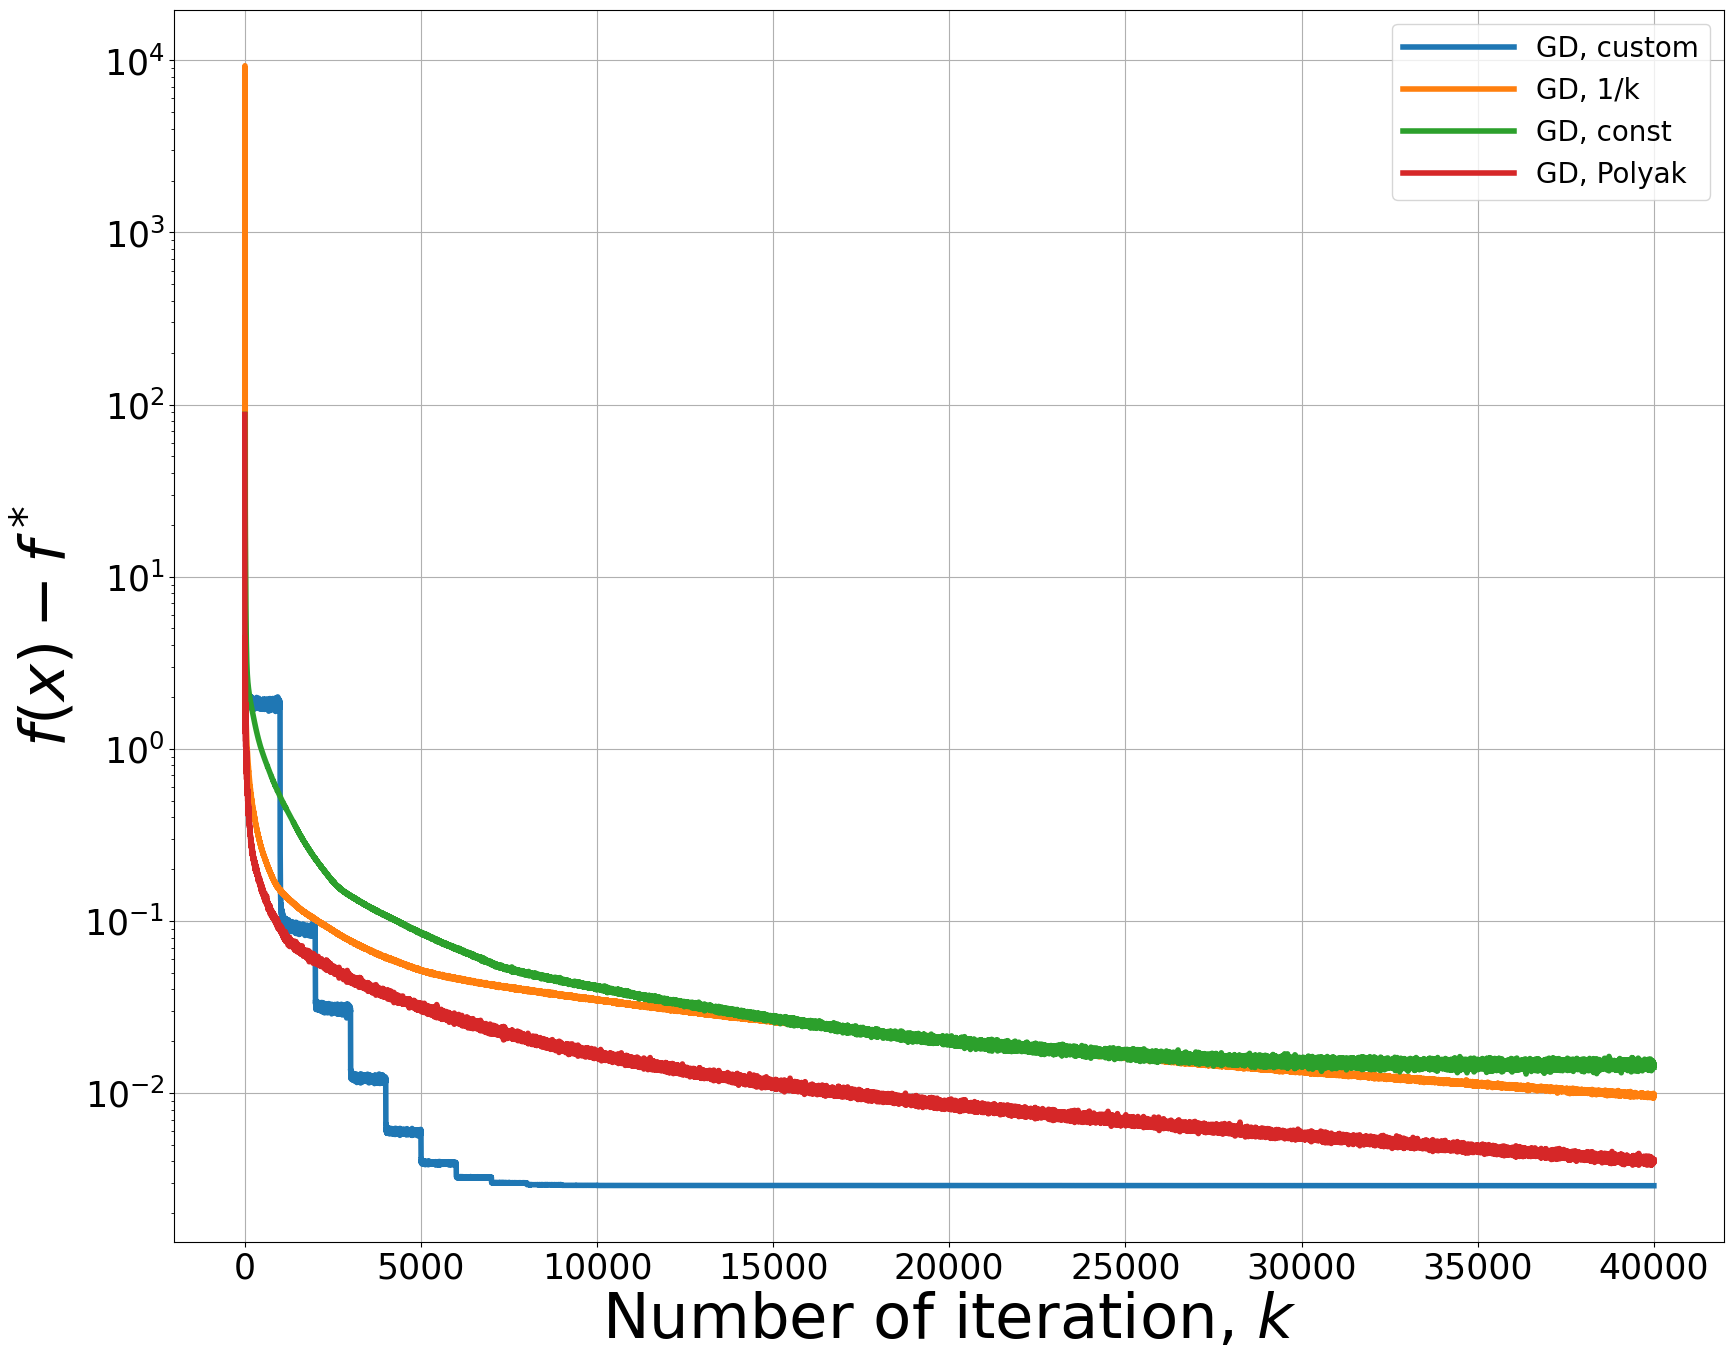

In [27]:
plt.figure(figsize=(20, 16))
obj_val = obj.value
funcx = lambda x: f(x) - obj_val
# funcx = lambda x: f(x)
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)
plt.grid()
plt.ylabel(r"$f(x) - f^*$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend();

In [28]:
np.sum(np.abs(x)<=1e-9), np.sum(np.abs(x)<=1e-4)

(0, 237)

## Эксперимент 5. Субградиентный метод с переключениями

Решим негладкую задачу:

$f(x) = \sqrt{0.1} \left( \sum_{i=1}^{n-1} \left| x_i - x_{i-1} \right| + \sum_{i=0}^{n-1} \left( x_i + \sqrt{i} \right) \right)^{\frac{1}{2}}$

С ограничениями вида:
$g_m(x)=\alpha_{m 1}\left|x_1\right|+\alpha_{m 2}\left|x_2\right|+\ldots+\alpha_{m n}\left|x_n\right|-1$, где коэффициенты $\alpha_{ii}$ представлены матрицей

$$
\left(\begin{array}{ccccccc}
1 & 1 & 1 & 1 & \ldots & 1 & m \\
1 & 2 & 2 & 2 & \ldots & 2 & m \\
1 & 3 & 3 & 3 & \ldots & 3 & m \\
1 & 4 & 4 & 4 & \ldots & 4 & m \\
1 & 5 & 5 & 5 & \ldots & 5 & m \\
\ldots \ldots & \ldots & \ldots & \ldots & \ldots & \ldots \\
1 & m & m & m & \ldots & m & m
\end{array}\right)
$$

__Примечание__ В качестве ответа будем отрисовывать рекордное значение

In [29]:
class GradientDescentWithRestriction:
    def __init__(self, StepSizeChoice, StepRestrSizeChoice, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.StepRestrSizeChoice = StepRestrSizeChoice
        self.return_history = return_history
        self.history = []

    def solve(self, x0, f, g, gradf, gradg, tol=1e-9, max_iter=5000):
        self.history = [(f(x0), time.time())]
        x = x0.copy()
        k = 0
        x_prev = None

        i_prod = 0
        i_non_prod = 0
        while x_prev is None or np.linalg.norm(x - x_prev) > tol:
            if g(x) <= 0:
                h = -1 * gradf(x)
                alpha = self.StepSizeChoice(x, h, k, gradf, f)
                i_prod += 1
            else:
                h = -1 * gradg(x)
                alpha = self.StepRestrSizeChoice(x, h, k, gradg, g, np.linalg.norm(gradg(x)))
                i_non_prod += 1

            x_prev, x = x, x + alpha * h

            if self.return_history:
                self.history.append((f(x), time.time()))
            if k >= max_iter:
                break
            k += 1

        print("Продуктивные шаги " + self.name, i_prod)
        print("Непродуктивные шаги " + self.name, i_non_prod)

        return x

In [30]:
def func():
    c = 0.1 ** (-1 / 2)
    def f(x):
        n = len(x)
        return c * (np.sum(np.abs(x[1:n] - x[0:n - 1])) + np.sum(x + np.sqrt(np.arange(len(x))))) ** (1 / 2)
    return f

def grad_f():
    def f(x):
        n = len(x)
        c = np.sqrt(0.1) * 0.5
        mult = np.sum(np.abs(x[1:n] - x[0:n - 1])) + np.sum(x + np.sqrt(np.arange(len(x))))
        mult = mult ** (-1 / 2)
        grad_vec = [np.sign(x[0]) + 1] + \
                   [np.sign(x[i] - x[i - 1]) + np.sign(x[i + 1] - x[i]) for i in range(1, len(x) - 1)] + \
                   [np.sign(x[len(x) - 1]) + 1]
        return mult * c * np.array(grad_vec)
    return f

## Функции ограничений в матричной форме и их градиент
def func_g(A, cond_const):
    def f(x):
        return np.max((np.dot(A, np.transpose(np.abs(x))) - cond_const))
    return f

def grad_g(A, cond_const):
    def f(x):
        first_ind = np.argmax((np.dot(A, np.transpose(np.abs(x))) - cond_const))
        return np.sign(x) * np.transpose(A[first_ind])
    return f

Запуск решения через CVXPY

In [31]:
def check_in_cvx(A, n, epsilon):
    x = cp.Variable(n, pos=True)

    prob = cp.Problem(cp.Minimize(cp.tv(x) + cp.sum(x + cp.sqrt(np.arange(n)))),
                       [cp.max(A @ cp.abs(x)) <= epsilon])
    prob.solve()

    return x.value

Подготовим данные

In [32]:
np.random.seed(1)

n = 1000
m = 20
cond_const = 1
A = np.array([np.concatenate(([1], np.full(n - 2, i), [m])) for i in np.arange(1, m + 1)])
x0 = np.random.uniform(-0.1, 0.1, n)
cvxpy_sol = check_in_cvx(A, n, cond_const)

methods = [
    # GradientDescentWithRestriction(SeqStepSize(), ScaledConstantStepSize(1e-3), name="GD, sequential step size"),
    # GradientDescentWithRestriction(ScaledConstantStepSize(1e-7), ScaledConstantStepSize(1e-3), name="GD, scaled step size"),
    GradientDescentWithRestriction(PolyakStepSize(func()(cvxpy_sol)), ScaledConstantStepSize(1e-3), name="GD, Polyak")
]

results = []
for method in methods:
    results.append(method.solve(x0, func(), func_g(A, cond_const), grad_f(), grad_g(A, cond_const), tol=1e-7, max_iter=10000))

Продуктивные шаги GD, Polyak 67
Непродуктивные шаги GD, Polyak 3625


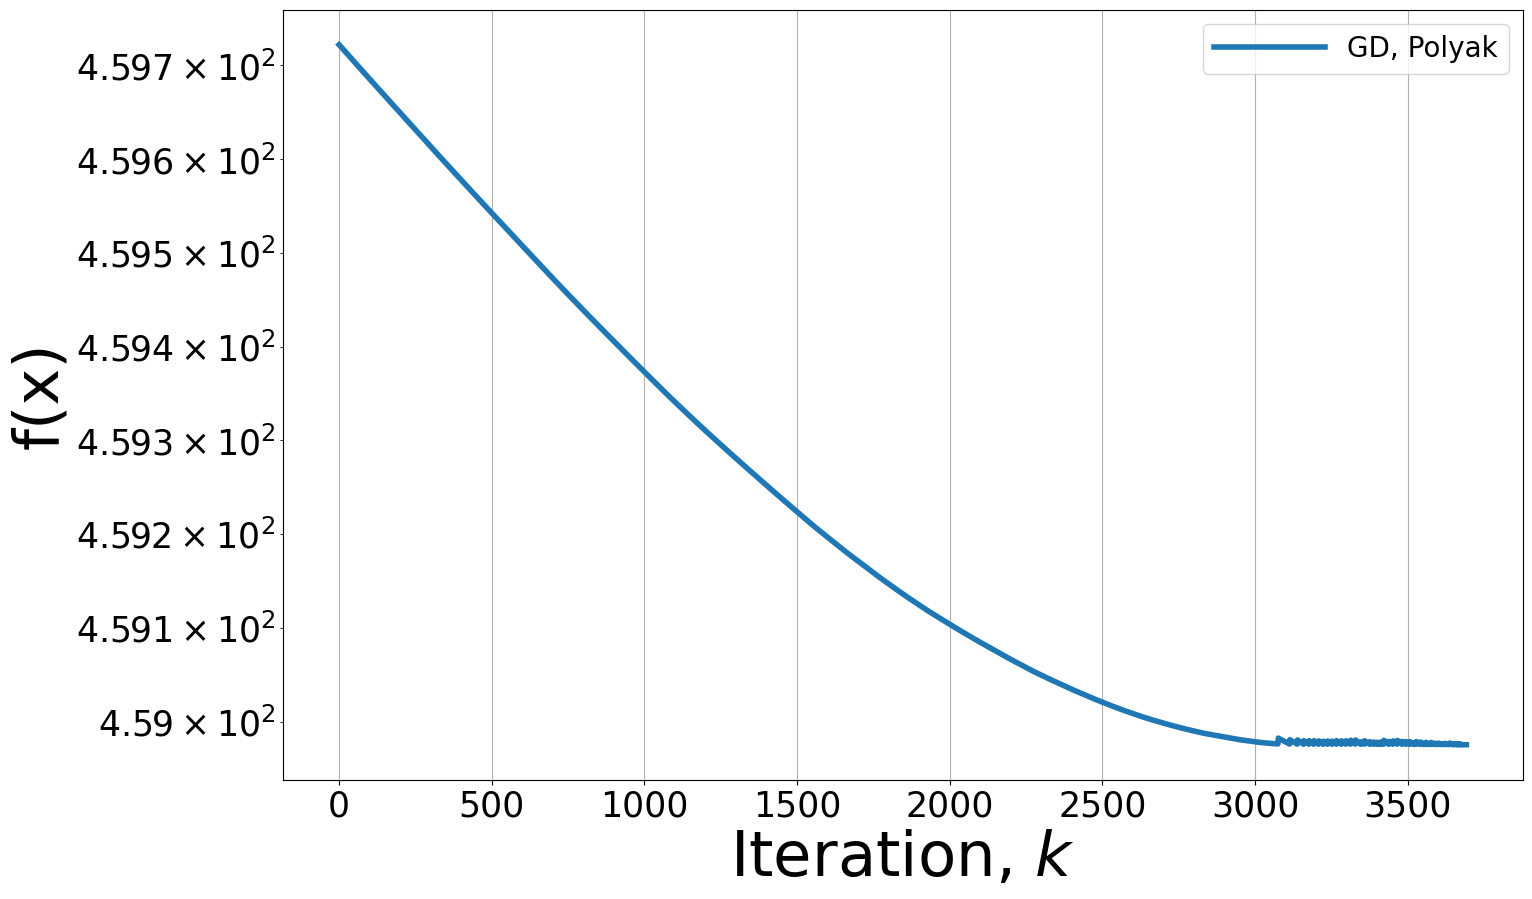

In [33]:
# %matplotlib inline
plt.figure(figsize=(16, 10))

results = []
for method in methods:
    times, values = parse_logs(method.history, ret_time=False, funcx=lambda v: v)
    values = np.array(values)
    results.append("Optimal X from " + method.name + " " + str(values.min()))
    plt.semilogy(times, values, label=method.name)
plt.grid()
plt.ylabel(r"f(x)")
plt.xlabel(r"Iteration, $k$")
plt.legend();

In [34]:
print("CVXPY solution", func()(cvxpy_sol))
[print(result) for result in results];

CVXPY solution 458.97530555443876
Optimal X from GD, Polyak 458.9753055564054
